# Learn Valid Words
The goal of this notebook is to train a model to discern between valid and invalid word candidates. The trained classifier should be able to take a five-letter sequence of characters and predict if it is a valid word or not.

## Approach
The _valid word attempt_ dataset is trained against several potential classifiers. Confusion matices are generated for each, including precision, recall, f1 and accuracy scores. Based on these scores a classifier is selected and manually tuned. Finally, samples of the predicted data are presented for inspection (false-positives, false-negatives, true-positives, true-negatives).

## Out of Scope
This notebook is intended as a smokescreen to aid in manually evaluating machine learning classifiers for this problem, and to serve as a tool in selecting one that looks promision. Automated bias detection, hyperparameter tuning and deployment (among other things) are not within the scope of what is intended for this notebook to achieve.

## Background on the dataset
The _valid word attempt_ dataset was generated from **Alurdle** games played by a bot on the alurdle game server. The bot generated random sequences of letters and has no way of discernining between a valid and invalid word. To assist in balancing the data, valid words from the dictionary are randomly injected. The resulting dataset provides a labeled mix of valid and invalid words that can be useful for ML training.

In [1]:
# Constants
S3_BUCKET_PATH="s3://ads-datasets/wordle-player"
S3_FLD_CSV="flat"
S3_FLD_PQT="parquet"

FILENAME_GAMETURNS_CSV = "game-turns.csv"
FILENAME_GAMETURNS_PQT = "game-turns.parquet"
FILENAME_VALIDWORDATTEMPTS_CSV = "valid-word-attempts.csv"
FILENAME_VALIDWORDATTEMPTS_PQT = "valid-word-attempts.parquet"

WORD_LENGTH = 5

In [2]:
# Helper dict to locate files in s3
src_raw = {
  S3_FLD_CSV: {
    'folder': S3_FLD_CSV,
    'file': {
      'gameturns': FILENAME_GAMETURNS_CSV,
      'validwordattempts': FILENAME_VALIDWORDATTEMPTS_CSV,
    }
  },
  S3_FLD_PQT: {
    'folder': S3_FLD_PQT,
    'file': {
      'gameturns': FILENAME_GAMETURNS_PQT,
      'validwordattempts': FILENAME_VALIDWORDATTEMPTS_PQT,
    }
  }
}

## Load and inspect the data

The *validwordattempts* and *gameturns* datasets are available in both CSV and parquet format in an S3 bucket. The *load_raw_data()* function takes care of reading the dataset into a Pandas DataFrame.

We load and inspect each dataset, though we're only interested in *validwordattempts* for now. We inspect the balance of *isValid* labels, noting a 30-70 split between (True / False).

In [3]:
import awswrangler as wr
import os

# Loads the raw data
def load_raw_data(format=S3_FLD_PQT, filename='gameturns'):
  bucket_path = S3_BUCKET_PATH
  fld_format = src_raw[format]['folder']
  file_name = src_raw[format]['file'][filename]

  path = os.path.join(bucket_path, fld_format, file_name)

  return wr.s3.read_parquet(path=path)

In [4]:
# Inspect game turns data from parquet 
df = load_raw_data(format=S3_FLD_PQT, filename='gameturns')
df.head()

,gameId,turns
0,c7q67hdsi8ns738u2vm0,"[{'guess': 'LEACH', 'isValid': True, 'tryResul..."
1,c7q67klsi8ns738u36dg,"[{'guess': 'ACXNX', 'isValid': False, 'tryResu..."
2,c7q67ktsi8ns738u36vg,"[{'guess': 'ALUZV', 'isValid': False, 'tryResu..."
3,c7q67l5si8ns738u37ag,"[{'guess': 'UBUHK', 'isValid': False, 'tryResu..."
4,c7q67l5si8ns738u37fg,"[{'guess': 'VHERY', 'isValid': False, 'tryResu..."


In [5]:
# Inspect valid word attempt data from parquet 
df = load_raw_data(format=S3_FLD_PQT, filename='validwordattempts')
df.head()

,guess,isValid,gameId
0,LEACH,True,c7q67hdsi8ns738u2vm0
1,BNVUX,False,c7q67hdsi8ns738u2vm0
2,NHBLJ,False,c7q67hdsi8ns738u2vm0
3,JZJKV,False,c7q67hdsi8ns738u2vm0
4,HCPXK,False,c7q67hdsi8ns738u2vm0


In [6]:
import pandas as pd

# Inspect the imbalance of isValid rows
df_label_counts = pd.DataFrame(df['isValid'].value_counts(normalize=True))
df_label_counts

,isValid
False,0.702346
True,0.297654


## Prepare the data for training

Now available in a DataFrame, the data needs to be prepared and split into training and test sets. We start by using *prepare_valid_word_data()* to break each word into individual characters and split the set, holding back 10% of the data for testing. 

The *train_classifier()* function one-hot encodes the letters into numpy arrays so that each can be used as a separate feature. The transformed X and y training data is then fit by the classifier, which is passed as a parameter allowing the training function to be reused with a variety of classifiers.

The *predict_from_classifier()* function uses the same one-hot encoder to transform input for inferencing using the trained classifier, which is passed in as a parameter.


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

letter_cols = [f'l{n}' for n in range(WORD_LENGTH)]

# Prepare valid words dataset
def prepare_valid_word_data(format=S3_FLD_PQT, filename='validwordattempts', test_size=0.1):
  df = load_raw_data(format=S3_FLD_PQT, filename='validwordattempts')

  # Split each guess word to letters in individual columns
  df = df.join(
    pd.DataFrame(
      [list(w) for w in df['guess']], 
      columns=letter_cols)
    )
  
  # Training-testing split
  y = df['isValid'].astype(int)
  X = df.drop(['isValid'], axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)

  return X_train, X_test, y_train, y_test


In [8]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import compute_class_weight

# Train a classifier
def train_classifier(X_train, y_train, clf=LogisticRegression()):
  global ohe 

  # One-hot encode the letters
  ohe = OneHotEncoder(handle_unknown='error')
  X_train_ohe = ohe.fit_transform(X_train[letter_cols])

  # Fit the training data
  clf.fit(X_train_ohe, y_train.to_numpy())
  
  return clf


# Predict from a trained classifier
def predict_from_classifier(X, clf):
  global ohe
  X_ohe = ohe.transform(X[letter_cols])

  return clf.predict(X_ohe)


## Visualizing the results

We will evaluate the accuracy of each model with the help of a confusion matrix, together with a breakdown of precision, recall and f1 scores for each label. The *plot_confusion_matrix()* calculates the scores for each model's predictions and prepares the plots.

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score

# Plot results as a confusion matrix
def plot_confusion_matrix(name, prediction, y_test):
  accuracy = accuracy_score(y_true=y_test, y_pred=prediction)
  f1 = f1_score(y_true=y_test, y_pred=prediction)
  precision = precision_score(y_true=y_test, y_pred=prediction)
  recall = recall_score(y_true=y_test, y_pred=prediction)

  cf_matrix = confusion_matrix(y_true=y_test, y_pred=prediction)

  group_names = ['True Neg','False Neg','False Pos','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  summary_text = classification_report(y_true=y_test, y_pred=prediction)

  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)

  figsize = plt.rcParams.get('figure.figsize')
  plt.figure(figsize=figsize)
  sns.heatmap(
    cf_matrix/np.sum(cf_matrix), 
    annot=labels,
    fmt='', 
    cmap='Blues')
  plt.xlabel(name + '\n' + summary_text)

  return classification_report(y_true=y_test, y_pred=prediction)

  

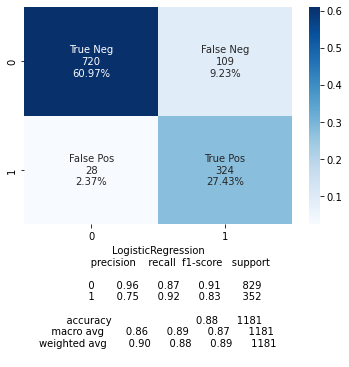

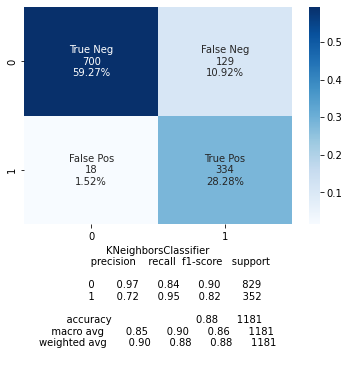

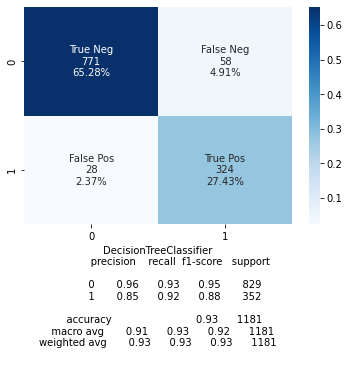

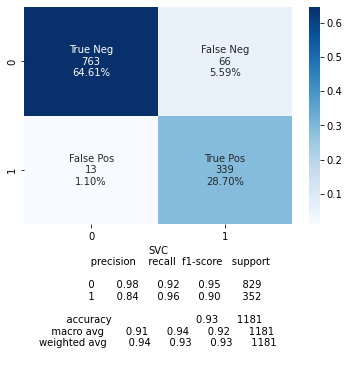

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Try a few different classifiers
clf_dict = {
  'LogisticRegression': LogisticRegression(class_weight='balanced'),
  'KNeighborsClassifier': KNeighborsClassifier(),
  'DecisionTreeClassifier': DecisionTreeClassifier(class_weight='balanced'),
  'SVC': SVC(class_weight='balanced'),
}

# Load and prep the data
X_train, X_test, y_train, y_test = prepare_valid_word_data()

# Train and plot the confusion matrices
for name in clf_dict:
  clf = clf_dict[name]
  model = train_classifier(X_train, y_train, clf)
  prediction = predict_from_classifier(X_test, model)
  plot_confusion_matrix(name, prediction, y_test)


## Model selection, tuning and output

Between the models evaluated above, SVC stands out as the strongest performer. 

We use the next cell to run it again, manually adjusting its hyperparameters to further improve its performance. We observe that using the poly kernel provides higher f1 scores with a smaller spread between classes and a higher overall accuracy.

Having retrained the classifier, we inspect samples of the predictions that it has produced. Noting that the precision score for the *True* class is low compared with the precision and recall scores of the other classes, we are especially interested in reviewing the false positives and false negatives.

'              precision    recall  f1-score   support\n\n           0       0.98      0.96      0.97       829\n           1       0.91      0.96      0.93       352\n\n    accuracy                           0.96      1181\n   macro avg       0.95      0.96      0.95      1181\nweighted avg       0.96      0.96      0.96      1181\n'

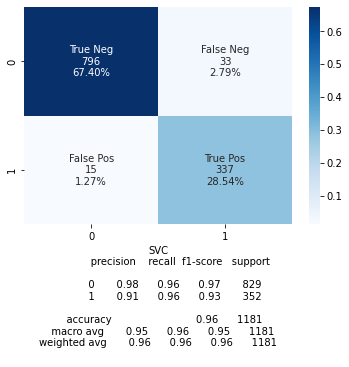

In [11]:
from sklearn.svm import SVC

# Use best performing classifier
clf = SVC(kernel='poly', degree=3, class_weight='balanced')

# Load and prep the data
X_train, X_test, y_train, y_test = prepare_valid_word_data()

# Train and plot the confusion matrices
model = train_classifier(X_train, y_train, clf)
prediction = predict_from_classifier(X_test, model)
plot_confusion_matrix(name, prediction, y_test)


In [12]:
# Inspect the test predictions
df_test_pred = X_test.join(y_test)
df_test_pred['prediction'] = prediction == y_test

# False negatives
df_test_pred_fn = df_test_pred[(df_test_pred['prediction'] == False) & (df_test_pred['isValid'] == 0)]
# False positives
df_test_pred_fp = df_test_pred[(df_test_pred['prediction'] == False) & (df_test_pred['isValid'] == 1)]
# True negatives
df_test_pred_tn = df_test_pred[(df_test_pred['prediction'] == True) & (df_test_pred['isValid'] == 0)]
# True positives
df_test_pred_tp = df_test_pred[(df_test_pred['prediction'] == True) & (df_test_pred['isValid'] == 1)]


In [13]:
df_test_pred_fp

,guess,gameId,l0,l1,l2,l3,l4,isValid,prediction
8438,CREDO,c7q6tjgqcq3c73e1fpng,C,R,E,D,O,1,False
4590,GYPSY,c7q6tfgqcq3c73e1fkl0,G,Y,P,S,Y,1,False
4428,WIDOW,c7q6tf8qcq3c73e1fkdg,W,I,D,O,W,1,False
2632,ZULUS,c7q6td8qcq3c73e1fi10,Z,U,L,U,S,1,False
7778,HERTZ,c7q6tioqcq3c73e1forg,H,E,R,T,Z,1,False
2389,OGRES,c7q6td0qcq3c73e1fhmg,O,G,R,E,S,1,False
10451,PHYLA,c7q6tloqcq3c73e1fscg,P,H,Y,L,A,1,False
1116,EXTOL,c7q6f2dsi8ns738u3nmg,E,X,T,O,L,1,False
9668,DAKAR,c7q6tkoqcq3c73e1frbg,D,A,K,A,R,1,False
5584,ABUZZ,c7q6tggqcq3c73e1flv0,A,B,U,Z,Z,1,False


In [14]:
df_test_pred_fn

,guess,gameId,l0,l1,l2,l3,l4,isValid,prediction
4099,SAGEE,c7q6teoqcq3c73e1fjvg,S,A,G,E,E,0,False
8093,NOWZY,c7q6tj8qcq3c73e1fp8g,N,O,W,Z,Y,0,False
6073,FIUOT,c7q6th0qcq3c73e1fmjg,F,I,U,O,T,0,False
10070,CMONE,c7q6tl8qcq3c73e1frsg,C,M,O,N,E,0,False
2256,POLTS,c7q6tcoqcq3c73e1fhh0,P,O,L,T,S,0,False
8402,CMETS,c7q6tjgqcq3c73e1fpm0,C,M,E,T,S,0,False
6767,UKFER,c7q6thoqcq3c73e1fnh0,U,K,F,E,R,0,False
8056,FIPAL,c7q6tj0qcq3c73e1fp70,F,I,P,A,L,0,False
5371,DIENO,c7q6tg8qcq3c73e1flm0,D,I,E,N,O,0,False
4071,BWONE,c7q6teoqcq3c73e1fju0,B,W,O,N,E,0,False


In [15]:
df_test_pred_tp

,guess,gameId,l0,l1,l2,l3,l4,isValid,prediction
5768,DONUT,c7q6tgoqcq3c73e1fm70,D,O,N,U,T,1,True
8408,TOOTH,c7q6tjgqcq3c73e1fpm0,T,O,O,T,H,1,True
8864,DUSKY,c7q6tk0qcq3c73e1fq9g,D,U,S,K,Y,1,True
7592,BADLY,c7q6tigqcq3c73e1fojg,B,A,D,L,Y,1,True
2588,TUNAS,c7q6td8qcq3c73e1fhv0,T,U,N,A,S,1,True
...,...,...,...,...,...,...,...,...,...
2282,DEPOT,c7q6td0qcq3c73e1fhig,D,E,P,O,T,1,True
3823,SEOUL,c7q6tegqcq3c73e1fjjg,S,E,O,U,L,1,True
10355,ARGUE,c7q6tlgqcq3c73e1fs80,A,R,G,U,E,1,True
6951,FETES,c7q6ti0qcq3c73e1fnog,F,E,T,E,S,1,True


In [16]:
df_test_pred_tn

,guess,gameId,l0,l1,l2,l3,l4,isValid,prediction
1500,OWZUP,c7q6tc0qcq3c73e1fghg,O,W,Z,U,P,0,True
130,JGMPH,c7q6f1lsi8ns738u3mbg,J,G,M,P,H,0,True
1851,QCBSM,c7q6tcgqcq3c73e1fh00,Q,C,B,S,M,0,True
1496,HDYEN,c7q6tc0qcq3c73e1fghg,H,D,Y,E,N,0,True
8600,MDBHX,c7q6tjoqcq3c73e1fpu0,M,D,B,H,X,0,True
...,...,...,...,...,...,...,...,...,...
4283,NNUOF,c7q6tf0qcq3c73e1fk7g,N,N,U,O,F,0,True
7473,IFXKT,c7q6tigqcq3c73e1foeg,I,F,X,K,T,0,True
7800,GYPKG,c7q6tioqcq3c73e1fosg,G,Y,P,K,G,0,True
101,JURXW,c7q67p5si8ns738u3fg0,J,U,R,X,W,0,True
